# Noise plus sine wave fitting fun

Example notebook to look at how well we can fit sine wave data that is obscured by band-limited thermal noise. The setup is we amplifier the noise from a room temperature terminator by about 80dB. This gives us our 'pure' thermal noise sample.

To get our thermal noise plus signal sample we take the output of a a signal generator and insert it before the amplification (using a splitter/combiner rto mix it with our terminator). We also record a version of the clean sine wave.

Then we can look at how the frequency resolution of the measurement depends on various properties of the signal and noise. Chief amongst these are:
* The signal-to-noise ratio (a simple but misleading comparison)
* The bandwidth of the system
* The sampling rate
* The length of the measurement

## Variance of  frequency $f$
The expectation for the variance on frequency is the folllowing:
$$ \textrm{ var} \left[\hat{f} \right] = \frac{\textrm{ var} \left[\hat{\omega} \right]}{4 \pi^2} \geq   \frac{ 3 }{ \pi^2 \textrm{SNR}_P (R T^3 - \frac{T}{R}) }$$
where $f$ is frequency, $\omega$ is angular frequency ${SNR}_P=\frac{\frac{A^2}{2}}{\sigma^2}$ is the signal-to-noise ratio in terms of power (as $A$ is the sine wave amplitude, so $\frac{A^2}{2}$ is the mean square of the, and $\sigma$ is the standard deviation of the noise, $R$ is the sampling rate and $T$ is the observation time.



In [1]:
from PyScopeTools import PyScopeTools as pst
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.style
import matplotlib as mpl
import math
import scipy.fftpack
from scipy.signal import butter,filtfilt


# Import the curve_fit function
from scipy.optimize import curve_fit

#Set default figure size
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams.update({'font.size': 22})

In [2]:
# The below is the standard deviation of a pure noise sample with the sine wave generator turned off
#noiseStd=0.17231516392304297 #mV old setup with coupler
noiseStd=0.166 #mV new setup with splitter

def getDataSet(freqInMhz,ampInmV,tag):
    noisePlusSineList,timeList=pst.getScopeWaveforms("/Users/rjn/qtnm/data/noisePlusSine/npSine_"+str(freqInMhz)+"MHz_"+str(ampInmV)+"mV"+tag+".ch1.traces",True)
    justSineList,_=pst.getScopeWaveforms("/Users/rjn/qtnm/data/noisePlusSine/npSine_"+str(freqInMhz)+"MHz_"+str(ampInmV)+"mV"+tag+".ch3.traces",True)
    dt=timeList[1]-timeList[0]
    fs=1./dt
    return noisePlusSineList,justSineList,timeList,dt,fs



def zeroMeanWaveform(waveList):
   return waveList- np.mean(waveList,axis=1)[:,None]  #Need the [:,None] to expand 1D array to 2D array


def getSine(t,w,A,phi):
    """Function to return a simple sine 

    Args:
        t: The array of times
        w: The angular frequency
        A: The amplitude
        phi: The phase at t=0
 
     Returns:
        The sine values as an array

    """
    return A*np.sin((w*t)+phi)

def doSineWaveFit(waveList,guessFreq,guessAmp=0):
    numWaveforms=waveList.shape[0]
    guessOmega=guessFreq*2*math.pi
    if guessAmp == 0:
        guessAmp=np.max(waveList[0])
    guessPhase=0

    omegas=np.zeros(numWaveforms)
    freqs=np.zeros(numWaveforms)
    amps=np.zeros(numWaveforms)
    phases=np.zeros(numWaveforms)
    failCount=0

    for i in range(numWaveforms):
        try:
            parameters, covariance = curve_fit(getSine, timeList, waveList[i],p0=[guessOmega,guessAmp,guessPhase])
        except:
            print("Failure ",failCount," to fit",i)
            failCount=failCount+1
            if(failCount>10):
                raise Exception("Sorry I've given up after failing to fit",failCount)
        
        omegas[i]=parameters[0]
        freqs[i]=parameters[0]/(2*math.pi)
        amps[i]=parameters[1]
        phases[i]=parameters[2]
        if i <2 :
            print(i,len(waveList[i]),freqs[i])
    return omegas,freqs,amps,phases
  



In [3]:
freqList=[200,250,300,350,400,450,500]
thisAmp=200#mV

jsStdList=[]
npsStdList=[]




npsFitAmpMeanList=[]
npsFitAmpStdList=[]

def trimAndDownsample(array,start,stop,step):
    if array.ndim==2:
        return array[:,start:stop:step]
    else:
        return array[start:stop:step]


    
    
#for thisAmp in ampList:
for thisFreq in freqList:
    print("Starting",thisFreq,thisAmp)
    #noisePlusSineList,justSineList,timeList,dt,fs=getDataSet(thisFreq,thisAmp,"_50dBatten_highpass")
    noisePlusSineList,justSineList,timeList,dt,fs=getDataSet(thisFreq,thisAmp,"_oct03")
    
    #Now we are going to reshape our array to have fewer entries
    start=0 #Start index
    stop=100000 #Stop index
    step=10 #Step size (1 is every sample, 2 is every other etc.)
    justSineList=trimAndDownsample(justSineList,start, stop,step)
    noisePlusSineList=trimAndDownsample(noisePlusSineList,start, stop,step)
    timeList=trimAndDownsample(timeList,start, stop,step)
    N=len(timeList)
    dt=timeList[1]-timeList[0]
    fs=1/dt
    jsOmega,jsFreq,jsAmp,jsPhase=doSineWaveFit(justSineList,thisFreq)#,1.4e-4*thisAmp)
    %time npsOmega,npsFreq,npsAmp,npsPhase=doSineWaveFit(noisePlusSineList,thisFreq)#,2.4e-3*thisAmp)
    print(jsFreq[0],npsFreq[0])
    
    jsStdList.append(np.std(jsFreq))
    npsStdList.append(np.std(npsFreq))
    npsFitAmpMeanList.append(np.mean(npsAmp))
    npsFitAmpStdList.append(np.std(npsAmp))
    


Starting 200 200
Found 1000 waveforms with 400002 samples
Found 1000 waveforms with 400002 samples
0 10000 200.00027555629333
1 10000 200.00039171670943
0 10000 199.99829973420069
1 10000 200.00033359440943
CPU times: user 2.58 s, sys: 325 ms, total: 2.91 s
Wall time: 3.06 s
200.00027555629333 199.99829973420069
Starting 250 200
Found 1000 waveforms with 400002 samples
Found 1000 waveforms with 400002 samples
0 10000 250.000422210136
1 10000 250.00005375259704
0 10000 249.99951474700552
1 10000 250.00045706168248
CPU times: user 2.2 s, sys: 233 ms, total: 2.43 s
Wall time: 2.56 s
250.000422210136 249.99951474700552
Starting 300 200
Found 1000 waveforms with 400002 samples
Found 1000 waveforms with 400002 samples
0 10000 300.0002944615785
1 10000 300.0003719320172
0 10000 299.9994023708339
1 10000 300.00055547005525
CPU times: user 2.16 s, sys: 156 ms, total: 2.32 s
Wall time: 2.46 s
300.0002944615785 299.9994023708339
Starting 350 200
Found 1000 waveforms with 400002 samples
Found 1000

/Users/rjn/miniforge3/envs/ml-env/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


CPU times: user 2.39 s, sys: 337 ms, total: 2.73 s
Wall time: 2.83 s
400.000783791517 400.0015636998405
Starting 450 200
Found 1000 waveforms with 400002 samples
Found 1000 waveforms with 400002 samples
0 10000 450.0006413044141
1 10000 450.00075445008207
0 10000 450.0017318293191
1 10000 450.0017590013617
CPU times: user 2.43 s, sys: 277 ms, total: 2.7 s
Wall time: 2.77 s
450.0006413044141 450.0017318293191
Starting 500 200
Found 1000 waveforms with 400002 samples
Found 1000 waveforms with 400002 samples
0 10000 500.00069649399023
1 10000 500.00070943199654
0 10000 500.0026863769463
1 10000 499.99956469132036
CPU times: user 2.39 s, sys: 285 ms, total: 2.67 s
Wall time: 2.75 s
500.00069649399023 500.0026863769463


Text(0.5, 1.0, 'Using 10000 points at 2000 MSa/s')

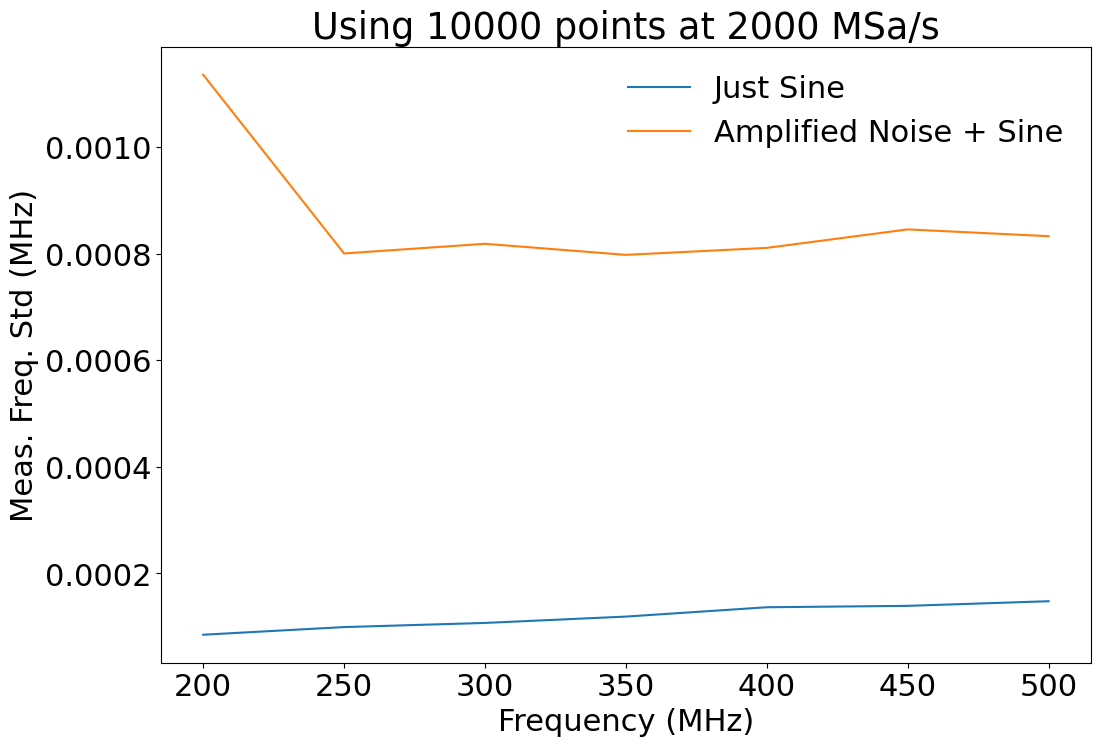

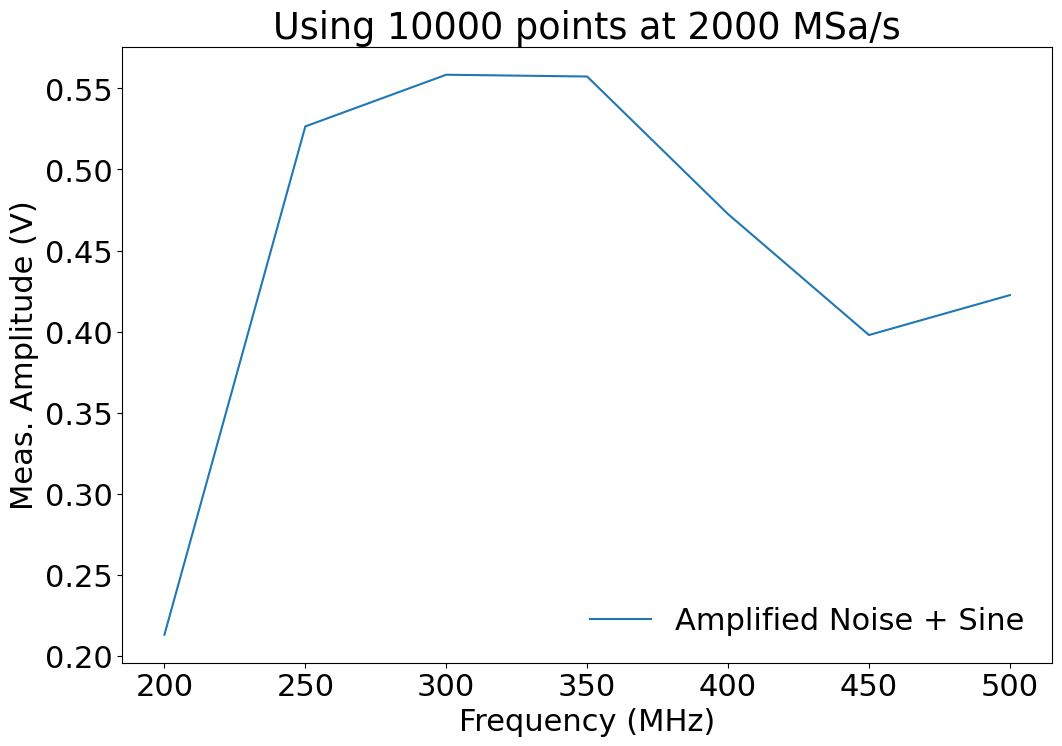

In [4]:
fig,ax = plt.subplots()
ax.plot(freqList,jsStdList,label="Just Sine")
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Meas. Freq. Std (MHz)")
ax.plot(freqList,npsStdList,label="Amplified Noise + Sine")
ax.set_ylabel("Meas. Freq. Std (MHz)")
ax.legend()
ax.set_title("Using "+str(N)+" points at "+str(int(np.round(fs,0)))+" MSa/s")


fig,ax = plt.subplots()
ax.plot(freqList,npsFitAmpMeanList,label="Amplified Noise + Sine")
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Meas. Amplitude (V)")
ax.legend()
ax.set_title("Using "+str(N)+" points at "+str(int(np.round(fs,0)))+" MSa/s")



## Variance of  frequency $f$
$$ \textrm{ var} \left[\hat{f} \right] = \frac{\textrm{ var} \left[\hat{\omega} \right]}{4 \pi^2} \geq   \frac{ 3 }{ \pi^2 \textrm{SNR}_P (R T^3 - \frac{T}{R}) }$$


1999.9999732953602 4.9995000667504845
1999999973.29536 4.999500066750484e-06


Text(0.5, 1.0, 'Using 10000 points at 2000 MSa/s')

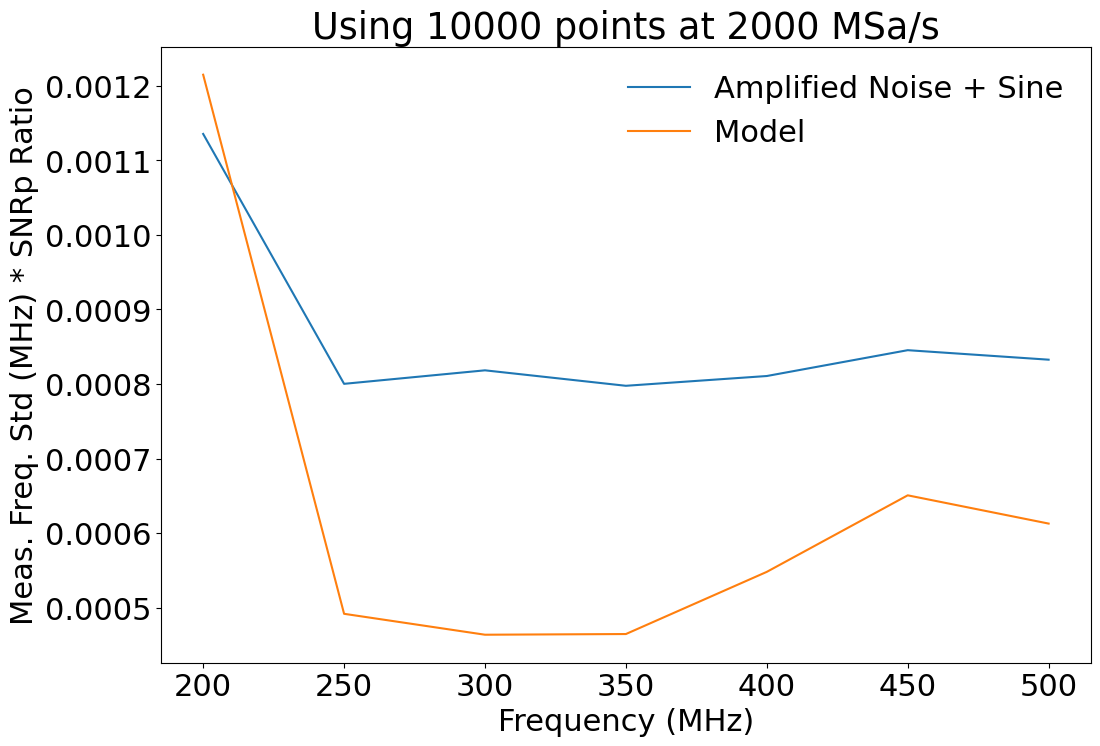

In [5]:
R=fs
T=timeList[-1]-timeList[0]

print(R,T)

#Convert to Hz,s
R=1e6*R
T=1e-6*T
print(R,T)


def getEstFreqVariance(snrp,samplingRate,observationTime):
    return 3 / (math.pi**2 *(snrp*(samplingRate*observationTime**3 - observationTime/samplingRate)))

measSNRp=(np.array(npsFitAmpMeanList)**2)/(2*noiseStd**2)
fig,ax = plt.subplots()
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Meas. Freq. Std (MHz)")
ax.plot(freqList,npsStdList,label="Amplified Noise + Sine")
ax.plot(freqList,np.sqrt(getEstFreqVariance(measSNRp,R,T))/1e6,label="Model")
ax.set_ylabel("Meas. Freq. Std (MHz) * SNRp Ratio")
ax.legend()
ax.set_title("Using "+str(N)+" points at "+str(int(np.round(fs,0)))+" MSa/s")


In [9]:

def trimAndDownsample(array,start,stop,step):
    if array.ndim==2:
        return array[:,start:stop:step]
    else:
        return array[start:stop:step]

stepFreqMean=[]
stepFreqStd=[]
stepAmpMean=[]
stepAmpStd=[]
stepArray=np.arange(1,41,5)
msaPerSecArray=np.zeros(len(stepArray))

for ind,step in enumerate(stepArray):
    print("Starting step size",step)
    nnpsFitAmpMeanList=[]
    nnpsFitAmpStdList=[]
    nnpsFitFreqMeanList=[]
    nnpsFitFreqStdList=[]

    
    for thisFreq in freqList:
        print("Starting",thisFreq,thisAmp)
        npsList,jsList,tList,dt,fs=getDataSet(thisFreq,thisAmp,"_oct03")
        
        #Now we are going to reshape our array to have fewer entries
        start=0 #Start index
        stop=10000 #Stop index
        nnpsList=trimAndDownsample(npsList,start,stop,step)
        njsList=trimAndDownsample(jsList,start,stop,step)
        ntList=trimAndDownsample(tList,start,stop,step)
        N=ntList.shape[0] #
        dt=ntList[1]-ntList[0]
        fs=1./dt
        msaPerSecArray[ind]=fs
        timeList=ntList
        nnpsOmega,nnpsFreq,nnpsAmp,nnpsPhase=doSineWaveFit(nnpsList,thisFreq,2.4e-3*thisAmp)
        nnpsFitAmpMeanList.append(np.mean(nnpsAmp))
        nnpsFitAmpStdList.append(np.std(nnpsAmp))
        nnpsFitFreqMeanList.append(np.mean(nnpsFreq))
        nnpsFitFreqStdList.append(np.std(nnpsFreq))
        print(np.shape(timeList))
        print("Freq std",np.std(nnpsFreq))
    stepFreqMean.append(np.array(nnpsFitFreqMeanList))
    stepFreqStd.append(np.array(nnpsFitFreqStdList))
    stepAmpMean.append(np.array(nnpsFitAmpMeanList))
    stepAmpStd.append(np.array(nnpsFitAmpStdList))
    

Starting step size 1
Starting 200 200
Found 1000 waveforms with 400002 samples
Found 1000 waveforms with 400002 samples
0 100000 199.99860980452533
1 100000 200.00038840471458
(100000,)
Freq std 0.001125612853298652
Starting 250 200
Found 1000 waveforms with 400002 samples
Found 1000 waveforms with 400002 samples
0 100000 249.99962910505124
1 100000 250.00043909225644
(100000,)
Freq std 0.0008017792192168855
Starting 300 200
Found 1000 waveforms with 400002 samples
Found 1000 waveforms with 400002 samples
0 100000 299.9994179545446
1 100000 300.0005493717795
(100000,)
Freq std 0.0008130810178014588
Starting 350 200
Found 1000 waveforms with 400002 samples
Found 1000 waveforms with 400002 samples
0 100000 350.00012802429296
1 100000 349.99965306311077
Failure  0  to fit 174
(100000,)
Freq std 0.0007966138646646714
Starting 400 200
Found 1000 waveforms with 400002 samples
Found 1000 waveforms with 400002 samples
0 100000 400.0014606063565
1 100000 400.0007401799756
(100000,)
Freq std 0.0

Text(0, 0.5, 'Mean Amplitude (V)')

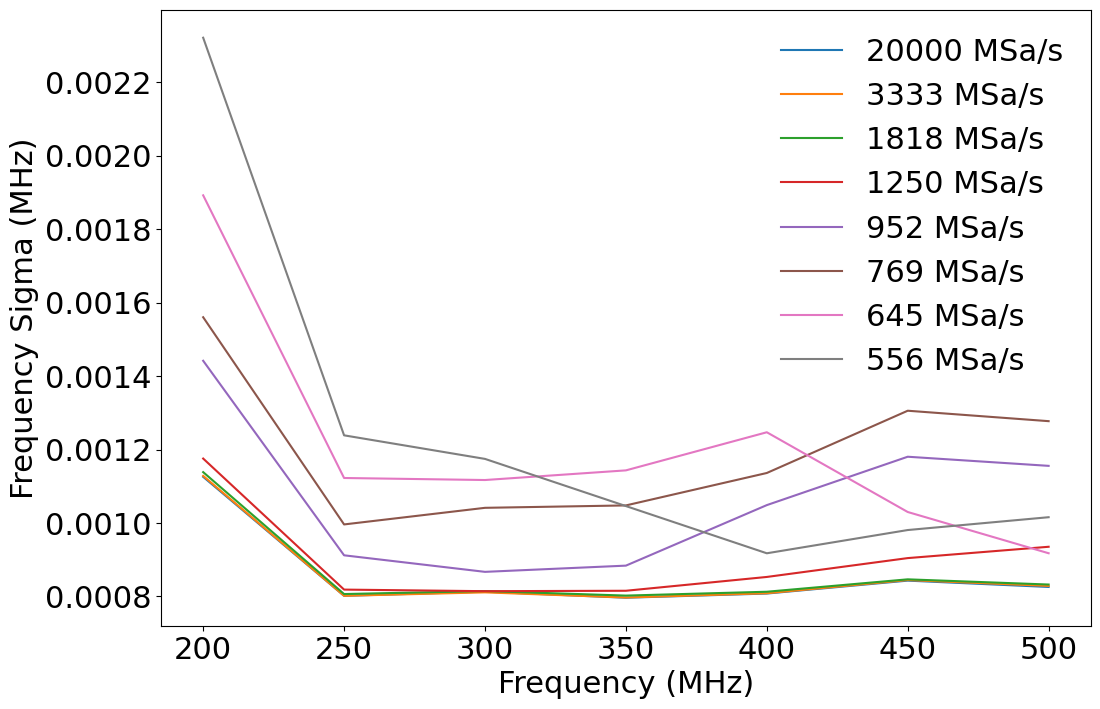

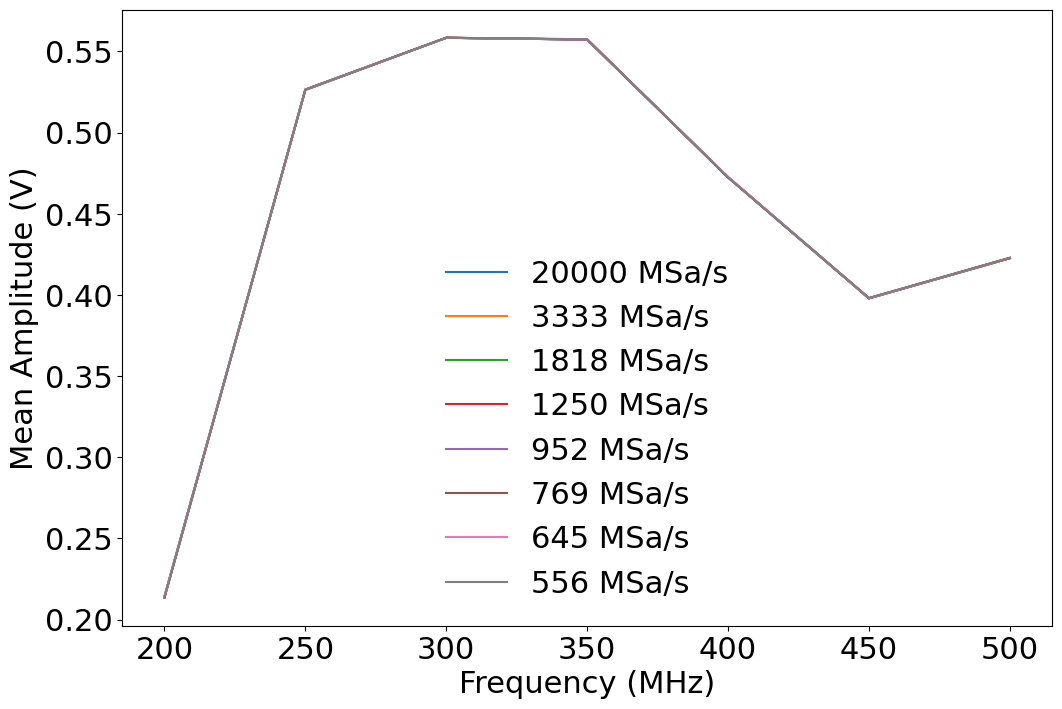

In [12]:
fig,ax = plt.subplots()
for i in range(len(msaPerSecArray)):
    ax.plot(freqList,stepFreqStd[i],label=str(int(np.round(msaPerSecArray[i],0)))+" MSa/s")
#ax.plot(ampList,np.sqrt(getEstFreqVariance(measSNRp,1000e6,T))/1e6,label="From Formula")
ax.legend()
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Frequency Sigma (MHz)")

fig,ax = plt.subplots()
for i in range(len(msaPerSecArray)):
    ax.plot(freqList,stepAmpMean[i],label=str(int(np.round(msaPerSecArray[i],0)))+" MSa/s")
#ax.plot(ampList,np.sqrt(getEstFreqVariance(measSNRp,1000e6,T))/1e6,label="From Formula")
ax.legend()
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Mean Amplitude (V)")


[19999.99973288  3333.33328881  1818.1817939   1249.99998331
   952.38093966   769.23075896   645.16128171   555.55554814]
[0.00112561 0.0011282  0.00113842 0.00117538 0.00144152 0.00156004
 0.00189178 0.00232075]
[19999.99973288  3333.33328881  1818.1817939   1249.99998331
   952.38093966   769.23075896   645.16128171   555.55554814]
[0.00080178 0.00080184 0.00080663 0.00081872 0.00091206 0.00099608
 0.00112247 0.00123859]
[19999.99973288  3333.33328881  1818.1817939   1249.99998331
   952.38093966   769.23075896   645.16128171   555.55554814]
[0.00081308 0.00081119 0.00081479 0.00081441 0.00086702 0.00104129
 0.00111695 0.00117444]
[19999.99973288  3333.33328881  1818.1817939   1249.99998331
   952.38093966   769.23075896   645.16128171   555.55554814]
[0.00079661 0.00079717 0.00080241 0.00081556 0.00088395 0.00104782
 0.00114322 0.00104606]
[19999.99973288  3333.33328881  1818.1817939   1249.99998331
   952.38093966   769.23075896   645.16128171   555.55554814]
[0.00080798 0.0008087

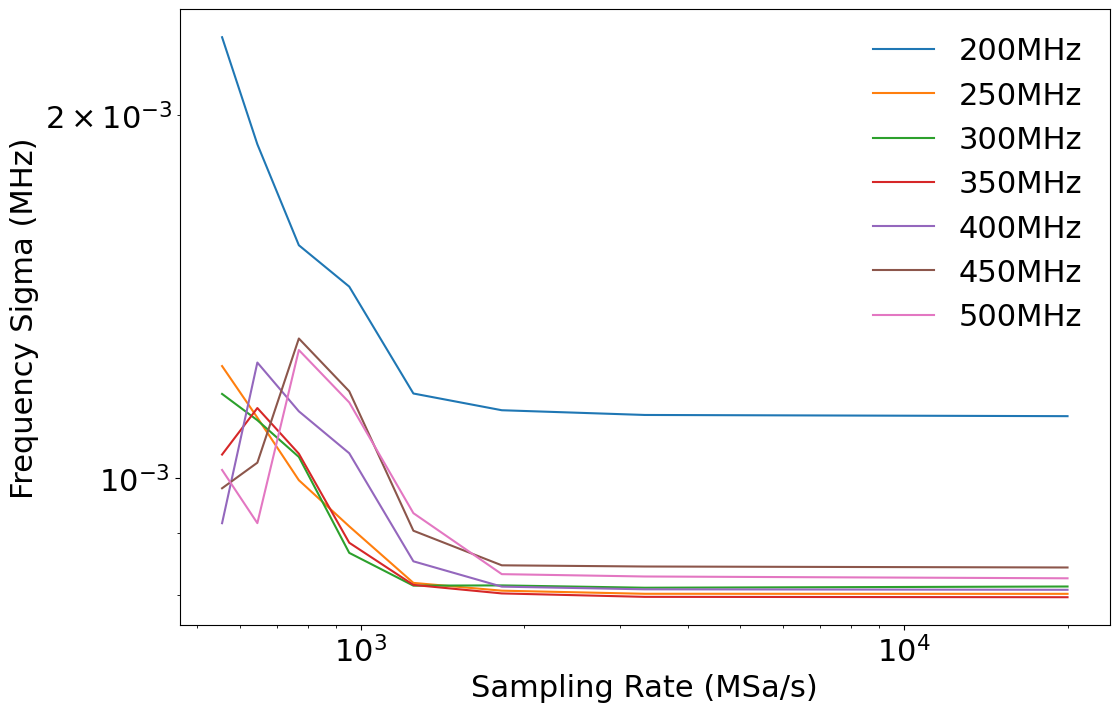

In [11]:
fig,ax = plt.subplots()
for i in range(len(freqList)):
    ax.plot(msaPerSecArray,np.array(stepFreqStd).T[i],label=str(int(np.round(freqList[i],0)))+"MHz")
    print(msaPerSecArray)
    print(np.array(stepFreqStd).T[i])
ax.legend()
ax.set_xlabel("Sampling Rate (MSa/s)")
ax.set_ylabel("Frequency Sigma (MHz)")
ax.set_yscale('log')
ax.set_xscale('log')

In [21]:
#These numbers come from long noise run
#Noise Power at 300MHz 5.275120931569428e-07 W
#Noise Power at 200MHz 1.7222588779137694e-07 W
for i in range(len(freqList)):
    print(freqList[i],np.array(stepAmpMean).T[i]**2/(2*50))
    
print((np.array(stepAmpMean).T[0]**2/(2*50))/1.7222588779137694e-07)
print((np.array(stepAmpMean).T[2]**2/(2*50))/5.275120931569428e-07)

200 [0.00045802 0.00045625 0.00045798 0.00045608 0.00045811 0.00045562
 0.00045792 0.00045593]
250 [0.00277252 0.00277225 0.0027725  0.00276948 0.002772   0.00277149
 0.00277166 0.00277182]
300 [0.00311865 0.00311902 0.00311865 0.00311873 0.00311896 0.00311861
 0.00311748 0.00311836]
350 [0.00310617 0.00310801 0.00310622 0.00310658 0.00310616 0.00310656
 0.00310714 0.00310866]
400 [0.00223254 0.002232   0.00223243 0.00223252 0.00223226 0.00223284
 0.0022348  0.00223124]
450 [0.00158327 0.00158387 0.00158327 0.00158417 0.00158255 0.00158388
 0.00158372 0.00158554]
500 [0.0017868  0.00178479 0.00178674 0.00178892 0.00178646 0.00178684
 0.00178681 0.00178743]
[2659.43041574 2649.12230619 2659.20475655 2648.12355989 2659.95461863
 2645.46352452 2658.84346847 2647.29631955]
[5911.98815722 5912.70044017 5911.99105421 5912.14352617 5912.57611861
 5911.91294098 5909.78068845 5911.44839039]
